#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Slippage can make or break a trading strategy:

This quip is well known. This notebook simply illustrates this important fact with a quick example, which was encountered in the process of backtesting my Three Moving Averages strategy. 

A few other important points worth noting: <br>
- While Zipline is great for realistic backtesting, the speed is so slow as to make any sort of optimization/cross validation impossible. Hence the need for stand-alone strategy functions like the 'three_moving_averages_cpcv' function below.
- Even though the speed of stand-alone strategy functions are more than a hundred times faster than that from Zipline backtesting, it might still be not fast enough. During the Combinatorial Purge Cross Validation process, this function might be called 50-80 times per split, 40-80 splits in total. We often would want to use a long time window for this process to include as many types of markets as possible. A period of one or two years or even longer is desirable. All of this means it might take a second or two to run the strategy through 500,000 to 1,000,000 rows of minute data points. It also means the whole CPCV process would take 30 minutes or longer to run through. 
- If a second is not fast enough, maybe we can try to improve the speed further! Vectorizing the strategy could be a solution, and was implemented for the Morning Trend Strategy. However, as will be apparent soon, vectorization has its own downsides that might overwhelm any potential speed benefit:
   - It is by no means easy to vectorize a trading strategy, especially one that is a little more complicated than the strategy below.
   - Even then, it is difficult to incorporate a number of important debugging features without compromising on the speed of the function. As is clear below, this debugging information proves much more important than any speed-boosting benefit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [3]:
df.index = df.index.tz_localize(None)

In [4]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [5]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [6]:
def three_moving_averages_cpcv(data, short, medium, long, profit_taking=.04, stop_loss=-.015):
    long_pos = False
    short_pos = False
    
    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    pos_ret = 0   # help debug
    neg_ret = 0   # help debug
    filled_price = 0
    PnL = 1
    cumRet = []
    
    # rolling function below has same effect as purging the data to avoid overlapped information in time series
    # purging is important in cross validating time series data. See Cross Validation chapter in Advances in FinML
    # cumRet returned by this function will thus have fewer data points than those from the original data input
    # embargoing the data can further improve the robustness of this process (to be implemented)
    # shift by 1 minute to avoid any kind of look forward bias
    data['sma_long'] = data.close.shift(1).rolling(long).mean()
    data['sma_med'] = data.close.shift(1).rolling(medium).mean()
    data['sma_short'] = data.close.shift(1).rolling(short).mean()
    data.dropna(inplace=True)
    data.index = data.index.astype(int)   # convert time stamp index to unix

    # to keep track of trades closed due to data jumping from one test/train group to another disparate one
    eop_close = 0         # help debug
    eop_prct_change = 1   # help debug
    jump = 0   # help debug
    last = [data.index[0], 0]   # just need last to be a tuple/list to be compatible with below
                                # when 'last' is assigned 'row'
    one_sec = 60*10**9   # since time was converted to unix 
    
    # loop through every minute data point in the dataset 
    # index=True to accommodate dealing with previous non-contiguous group
    for row in data.itertuples(index = True):
        current_price = row.close
        slow_mva = row.sma_long
        med_mva = row.sma_med
        fast_mva = row.sma_short
        has_pos = long_pos + short_pos
        
        # deal with positions from previous non-contiguous group
        if has_pos and row[0] - last[0] > one_sec: 
            if long_pos:
                prct_changed = (last.close - filled_price) / filled_price
            else:
                prct_changed = (filled_price - last.close) / filled_price
            jump += 1        # to help debug
            eop_close += 1   # to help debug
            eop_prct_change *= (1+prct_changed)   # to help debug
            PnL *= (1+prct_changed)
            if prct_changed > 0:
                pos_ret += 1
            else:
                neg_ret += 1           
            long_pos = False
            short_pos = False
        elif row[0] - last[0] > one_sec:
            jump += 1    # to help debug
        
        # put on short trades with some slippage added
        if not has_pos and fast_mva < med_mva and med_mva < slow_mva and fast_mva*.995 < current_price: 
            filled_price = current_price
            short_pos = True

        # put on long trades with some slippage added
        elif not has_pos and fast_mva > med_mva and med_mva > slow_mva and fast_mva*1.005 > current_price:
            filled_price = current_price
            long_pos = True

        # take profits or stop loss
        elif has_pos:
            if short_pos:
                prct_changed = (filled_price-current_price)/filled_price
            else:
                prct_changed = (current_price-filled_price)/filled_price
                
            if fast_mva >= med_mva and short_pos:
                short_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)    # record realized PnL
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif fast_mva <= med_mva and long_pos:
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)    # record realized PnL
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= profit_taking: 
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)
                take_profit += 1
            elif prct_changed <= stop_loss: 
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)
                stopped_out += 1
        cumRet.append(PnL)
        last = row   # added for CPCV compatibility
    
    data.index = pd.to_datetime(data.index)   # convert back to normal timestamp
    cumRet = pd.Series(cumRet, index=data.index)
    print('take profits:',take_profit, '\nstopped out:', stopped_out, 
          '\npos_ret:', pos_ret, '\nneg_ret:', neg_ret, '\neop_closes:',
          eop_close, '    eop_prct_change', eop_prct_change, '    jump:', jump, '\n')        
    
    import empyrical
    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))

#### Read in results of the Combinatorial Purged Cross Validation process for this strategy

The performance looks amazing!

In [2]:
returns_cv = pd.read_pickle('pickle/three_moving_averages_cpcv_8_3_50.pickle')

In [3]:
# helper function that returns cummulative returns from individual trades' returns

def cumRet_from_rets(rets):
    return (rets+1).cumprod()

In [4]:
cumRets = []
for i in range(len(returns_cv)):
    cumRets.append(cumRet_from_rets(returns_cv[i]))

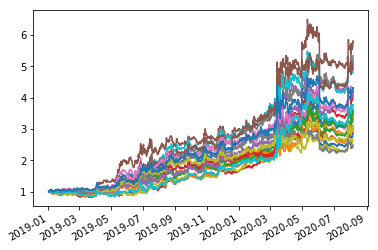

In [5]:
for i in range(len(cumRets)):
    cumRets[i].plot()

#### Run the CPCV strategy function on Jan and Feb of 2020

A short time period is enough to illustrate the point.

Notice the various data points that were printed out.

In [7]:
cumRet, pmdd = three_moving_averages_cpcv(df.loc['2020-01-01':'2020-03-01'].copy(), 100, 330, 4320)

take profits: 7 
stopped out: 9 
pos_ret: 69 
neg_ret: 119 
eop_closes: 0     eop_prct_change 1     jump: 0 



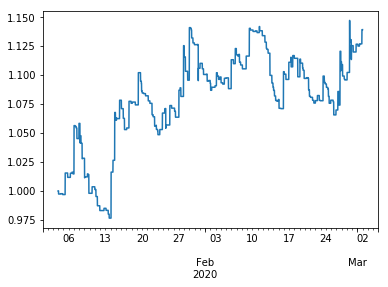

In [8]:
# Cummulative return for the stand-alone strategy function

cumRet.plot()

#### Read in the performance data from running this strategy in Zipline for the same time period. 

Notice how the cummulative return plot looks different from above. The numbers of take-profits and stop-losses are also fewer than those from the CPCV function. 

Digging in a little further, we can see that while the number of negative-return trades are in line with that from the CPCV function, there are about twenty fewer positive-return trades for the Zipline version. 

Finally, the plot of canceled orders shows about twenty trades - the number of 'missing' positive-return trades just mentioned above. 

This is a clear example of how slippage throws a wrench into the backtesting process. Even after incorporating some slippage into the CPCV function, the result is still not realistic enough. The difference in performance results between those from the CPCV function and those from Zipline backtest is significant enough to render unreliable the CPCV results plotted earlier. 

We will need to re-run the strategy through the CPCV process after incorporating more stringent slippage into the CPCV function. Afterwards, double checking the results with those from Zipline backtest is essential. 

All these steps are required before the strategy can be adopted into paper trading or live trading with low capital. 

In [9]:
perf = pd.read_pickle('pickle/3mva_jan1_march1_2020_100s_330m_4320l.pickle')

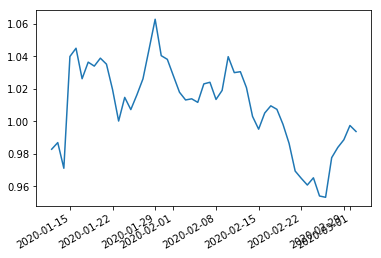

In [12]:
# Cummulative return for Zipline backtest version

(perf.algorithm_period_return+1).plot()

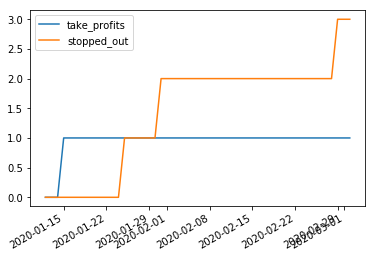

In [13]:
perf.take_profits.plot()
perf.stopped_out.plot()
plt.legend()

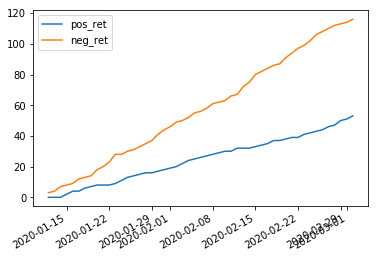

In [14]:
perf.pos_ret.plot()
perf.neg_ret.plot()
plt.legend()

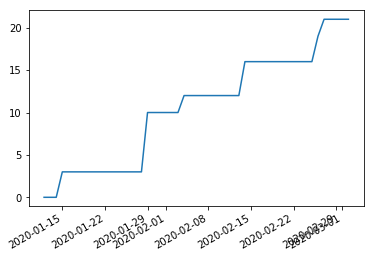

In [15]:
# the culprit!!

perf.cancelled.plot()